### Урок 7. Классификация с помощью KNN. Кластеризация K-means

#### Домашнее задание

1. К алгоритму kNN, реализованному на уроке, реализовать добавление весов для соседей по любому из показанных на уроке принципов.

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

In [2]:
import warnings
warnings.filterwarnings('ignore')

Загрузим один из "игрушечных" датасетов из sklearn.

In [3]:
X, y = load_iris(return_X_y=True)

# Для наглядности возьмем только первые два признака (всего в датасете их 4)
X = X[:, :2]

Разделим выборку на обучающую и тестовую

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=1,
                                                    stratify=y)

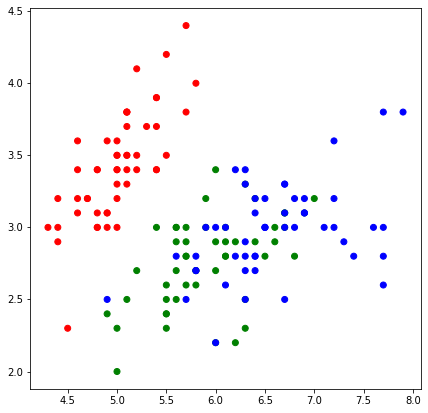

In [5]:
cmap = ListedColormap(['red', 'green', 'blue'])
plt.figure(figsize=(7, 7))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap);

Используем евклидову метрику. Реализуем функцию для ее подсчета.

In [6]:
def e_metrics(x1, x2):
    
    distance = 0
    for i in range(len(x1)):
        distance += np.square(x1[i] - x2[i])
        
    distance = np.sum(np.square(x1 - x2))

    return np.sqrt(distance)

Реализуем алгоритм поиска k ближайших соседей.

In [7]:
def knn(x_train, y_train, x_test, k):
    
    answers = []
    for x in x_test:
        test_distances = []
            
        for i in range(len(x_train)):
            
            # расчет расстояния от классифицируемого объекта до
            # объекта обучающей выборки
            distance = e_metrics(x, x_train[i])
            
            # Записываем в список значение расстояния и ответа на объекте обучающей выборки
            test_distances.append((distance, y_train[i]))
        
        # создаем словарь со всеми возможными классами
        classes = {class_item: 0 for class_item in set(y_train)}
        
        # ИЗМЕНЕНО
        dots = np.linspace(1, k, k)
        q = 0.25
        value = list(map(lambda x: q ** x, dots))
        i = 0
        
        # Сортируем список и среди первых k элементов подсчитаем частоту появления разных классов
        for d in sorted(test_distances)[0:k]:
            # ИЗМЕНЕНО
            classes[d[1]] += value[i]
            i += 1

        # Записываем в список ответов наиболее часто встречающийся класс
        answers.append(sorted(classes, key=classes.get)[-1])
        
    return answers

Напишем функцию для вычисления точности

In [8]:
def accuracy(pred, y):
    return (sum(pred == y) / len(y))

Проверим работу алгоритма при различных k

In [9]:
k = 2

y_pred = knn(X_train, y_train, X_test, k)

print(f'Точность алгоритма при k = {k}: {accuracy(y_pred, y_test):.3f}')

Точность алгоритма при k = 2: 0.700


Построим график распределения классов.

In [10]:
def get_graph(X_train, y_train, k):
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA','#00AAFF'])

    h = .02

    # Расчет пределов графика
    x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
    y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    print(np.c_[xx.ravel(), yy.ravel()].shape)

    # Получим предсказания для всех точек
    Z = knn(X_train, y_train, np.c_[xx.ravel(), yy.ravel()], k)
    # Построим график
    Z = np.array(Z).reshape(xx.shape)
    plt.figure(figsize=(7,7))
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # Добавим на график обучающую выборку
    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cmap)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title(f"Трехклассовая kNN классификация при k = {k}")
    plt.show()

(58800, 2)


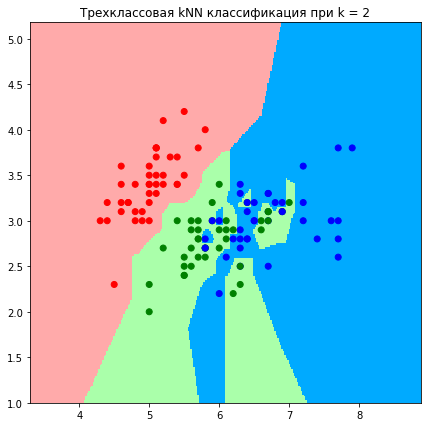

CPU times: total: 7min 44s
Wall time: 7min 48s


In [11]:
%%time
get_graph(X_train, y_train, k)

2. *Написать функцию подсчета метрики качества кластеризации как среднее квадратичное внутрикластерное расстояние и построить график ее зависимости от количества кластеров k (взять от 1 до 10) для выборки данных из данного урока (создать датасет, как в методичке).

In [12]:
def kmeans(data, k, max_iterations, min_distance):    
    # инициализируем центроиды как первые k элементов датасета
    centroids = [data[i] for i in range(k)]
    
    for _ in range(max_iterations):
        # Создадим словарь для классификации
        classes = {i: [] for i in range(k)}
        
        # классифицируем объекты по центроидам
        for x in data:
            # определим расстояния от объекта до каждого центроида
            distances = [e_metrics(x, centroid) for centroid in centroids]
            # отнесем объект к кластеру, до центроида которого наименьшее расстояние
            cluster = distances.index(min(distances))
            classes[cluster].append(x)
        
        # сохраним предыдущие центроиды в отдельный список для последующего сравнения сновыми
        old_centroids = centroids.copy()
        
        # пересчитаем центроиды как среднее по кластерам
        for cluster in classes:
            centroids[cluster] = np.average(classes[cluster], axis=0)
            
        # сравним величину смещения центроидов с минимальной
        optimal = True
        for centroid in range(len(centroids)):
            # ИЗМЕНЕНО
            if np.linalg.norm(centroids[centroid] - old_centroids[centroid], ord=2) > min_distance:
                optimal = False
                break
                
        # если все смещения меньше минимального, останавливаем алгоритм  
        if optimal:
            break
    
    return old_centroids, classes

In [13]:
def mean_sq_inclass_dist(centroids, clusters):
    inclass_distances = {}
    sum_inclass_distances = 0
    for key in clusters:
        sq_distance = 0
        for value in clusters[key]:
            distance = e_metrics(value, centroids[key])
            sq_distance += distance**2
        inclass_distances[key] = sq_distance/len(clusters[key])
        sum_inclass_distances += inclass_distances[key]
    mean_distance = sum_inclass_distances/len(inclass_distances)
    return inclass_distances, mean_distance

In [14]:
# определим максимальное количество итераций
max_iterations = 1

# и минимальное расстояние между центроидами до пересчета и после него, при котором нужно остановить алгоритм
min_distance = 1e-4

x = np.arange(1, 11)
y = []
for k in x:
    centroids, clusters = kmeans(X, k, max_iterations, min_distance)
    inclass_distances, mean_distance = mean_sq_inclass_dist(centroids, clusters)
    y.append(mean_distance)

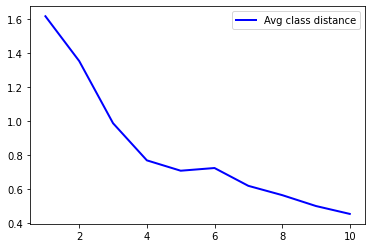

In [15]:
fig, ax = plt.subplots()
ax.plot(x, y, linestyle = '-', linewidth = 2, color = 'b', label='Avg class distance')
ax.legend();

3. *Оптимизировать код для KNN (оставить один цикл, либо обойтись без циклов вообще).

In [16]:
def knn(x_train, y_train, x_test, k):
    
    answers = []
    for x in x_test:
        test_distances = []
            
        for i in range(len(x_train)):
            
            # расчет расстояния от классифицируемого объекта до
            # объекта обучающей выборки
            distance = e_metrics(x, x_train[i])
            
            # Записываем в список значение расстояния и ответа на объекте обучающей выборки
            test_distances.append((distance, y_train[i]))
            
        # создаем словарь со всеми возможными классами
        classes = {class_item: 0 for class_item in set(y_train)}
        
        # Сортируем список и среди первых k элементов подсчитаем частоту появления разных классов
        for d in sorted(test_distances)[0:k]:
            classes[d[1]] += 1
            
        # Записываем в список ответов наиболее часто встречающийся класс
        answers.append(sorted(classes, key=classes.get)[-1])
        
    return answers

In [17]:
%%time
k = 4
n = 100
for i in range(n):
    y_pred = knn(X_train, y_train, X_test, k)

print(f'Точность алгоритма при k = {k}: {accuracy(y_pred, y_test):.3f}')

Точность алгоритма при k = 4: 0.700
CPU times: total: 22.6 s
Wall time: 23.1 s


In [18]:
def e_metrics_axis(x1, x2, axis=1):
    
    distance = np.sum(np.square(x1 - x2), axis=axis) # axis для суммы внутри строк

    return np.sqrt(distance)

In [19]:
np.set_printoptions(precision=50)

def knn_optimized(x_train, y_train, x_test, k):
    
    answers = []
    for x in x_test:
        distances = e_metrics_axis(x, x_train) # Расчёт всех расстояний через векторную операцию
        test_distances = np.array((distances, y_train)).T # Двумерный массив вида [[расстояние, класс]]
            
        classes = test_distances[test_distances[:, 0].argsort()][:k] # Сортироворка numpy массива по первому столбцу
        sums_by_class = np.bincount(classes[:, 1].astype(int), weights=classes[:, 0]) # Подсчёт весов по классам
        
        max_class = sums_by_class.argmax() # Индекс элемента с максимальным весом
            
        # Записываем в список ответов наиболее часто встречающийся класс
        answers.append(max_class)
        
    return answers

In [20]:
%%time
k = 4
n = 100
for i in range(n):
    y_pred = knn_optimized(X_train, y_train, X_test, k)

print(f'Точность алгоритма при k = {k}: {accuracy(y_pred, y_test):.3f}')

Точность алгоритма при k = 4: 0.700
CPU times: total: 500 ms
Wall time: 553 ms


In [40]:
if np.round(23.1*1000/553) > 0:
    print('Скорость расчёта больше примерно в', (np.round(23.1*1000/553)), 'раза')
else: False

Скорость расчёта больше примерно в 42.0 раза
